In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from IPython.display import clear_output 
import pickle

In [3]:
# forward euler params
g = 9.8 # gravity
l = 1 # length of pendulum rod
m = 1 # mass of bob
theta0 = np.radians(0) # intial angle
vel0 = 0 # initial velocity  
wind_scale = 2 # scale the wind
beta = 0.08 # damping factor
dt = 0.01 # step size for simulation
frequency = 0.5*np.pi * np.sqrt(g/l)

In [24]:
# video params
subsample_step_size = 10 # subsample (get every n frames)
fps = 1/(subsample_step_size*dt) 

# resolution
px = 80
py = 40

pad = 0.9 # shrink positions to fit in the frame
radius = 3 # size of bob

In [25]:
# gaussian process params
seed = 0

# number of timesteps for gaussian process
gp_total_time = 10 
gp_trunc_time = 6
gp_sparse_time = 4 #int(gp_trunc_time // 2)

# kernel parmas
length_scale = 2
sigma = 100

batch_size = 100
num_batches = 1

In [26]:
def draw_line(x0, y0, x1, y1, canvas):    
    # Round input coordinates to the nearest integers for starting points
    x0, y0 = round(x0), round(y0)
    x1, y1 = round(x1), round(y1)
    
    # Calculate the difference between the points
    dx = abs(x1 - x0) 
    dy = abs(y1 - y0)
    
    # Determine the direction of the line
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    
    # Error term
    err = dx - dy
    
    while True:
        # Add the current integer pixel coordinate to the list
        canvas[y0, x0] = 1        
        # Check if the endpoint is reached
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

In [27]:
def kernel_sq(X,Y, l=1, sigma=1):
    return sigma*np.exp(-0.5*(X[:,None]-Y[None,:])**2/(l**2))

In [28]:
# sample from gaussian process
def generate_path(batch_size, gp_trunc_time, gp_total_time, length_scale, sigma, seed=None):
    T = np.arange(gp_total_time)

    # define prior mean vector of zeros
    mu = np.zeros(np.size(T))
    
    # calculate covariance for x and y
    cov_x = 0.02*kernel_sq(T,T,l=length_scale, sigma=sigma)+1e-6*np.eye(gp_total_time)

    # array to hold trajectory
    trajectory = np.zeros((batch_size, gp_total_time, 1))

    # sample x trajectory from a gaussian process prior
    np.random.seed(1)
    trajectory[:,:,0] = np.random.multivariate_normal(mu, cov_x, batch_size)
    
    # create various trajectory types
    normal = trajectory[:,:gp_trunc_time].copy()
    sparse = trajectory[:,list(range(0, gp_trunc_time, 2))].copy()
    extrapolated = trajectory.copy()
    
    return normal, sparse, extrapolated

In [29]:
def gp_regression(x, y, batch_size):
    k = 0.02*kernel_sq(x,x,l=length_scale) + 1e-6
    k_inv = np.linalg.inv(k)
    def sample(x_test):
        kx = 0.02*kernel_sq(x,x_test,l=length_scale) + 1e-6
        kxx = 0.02*kernel_sq(x_test,x_test,l=length_scale) + 1e-6
        mean = np.matmul(np.matmul(kx.T, k_inv), y.T) # transpose y so batch dimension is last
        cov = kxx - np.matmul(np.matmul(kx.T, k_inv), kx)
        samples = []
        for mu in mean.T:
            samples.append(np.random.multivariate_normal(mu, cov))
        return np.stack(samples)
    return sample

In [30]:
def forward_euler(time, wind, g, l, m, theta0, vel0, dt, beta, wind_scale):
    i = 0
    timestep = 0
    thetas = []
    while i < time//dt*dt:
        a = l*np.cos(theta0)*wind_scale*wind[:, timestep] -2*beta*vel0-g/l*np.sin(theta0)
        new_theta = vel0 * dt + theta0
        new_vel = a * dt + vel0
        theta0 = new_theta
        vel0 = new_vel 
        thetas.append(theta0)
        timestep += 1
        i = timestep * dt
    return np.array(thetas).T

In [31]:
def compute_pendulum_motion(trajectory, gp_time, batch_size, dt, g, l, m, theta0, vel0, beta, wind_scale, subsample_step_size, px, py):
    wind_gp = gp_regression(np.arange(len(trajectory[0, :gp_time, 0])), trajectory[:,:gp_time, 0], batch_size)
    x_test = np.linspace(0, gp_time-1, int(gp_time/dt))
    wind = wind_gp(x_test) 
    
    #compute angle of pendulum with forward euler
    theta0 = np.zeros(batch_size)
    vel0 = np.zeros(batch_size)
    # thetas = forward_euler(gp_time, wind, g, l, m, theta0, vel0, dt, beta, wind_scale)
    thetas = np.expand_dims(forward_euler(gp_time, wind, g, l, m, theta0, vel0, dt, beta, wind_scale), 2)
    
    # split thetas up into frames
    subsampled_thetas = thetas[:,::subsample_step_size]

    # compute position of ball in each frame
    x_pos = l * np.sin(subsampled_thetas)*min(px, py)*pad + px/2
    y_pos = l * np.cos(subsampled_thetas)*min(px, py)*pad

    return x_pos, y_pos, subsampled_thetas, wind

In [32]:
def generate_batch(gp_sparse_time, gp_trunc_time, gp_total_time, px, py, length_scale, batch_size, seed, pad, radius, wind_scale, subsample_step_size):
    def rasterize_frames(xy):
        x = xy[0]
        y = xy[1]
        
        # generate array ranging from 0 to resolutions        
        # sq_x = (np.arange(px)[None, :] - x[:, None])**2
        # sq_y = (np.arange(py)[None, :] - y[:, None])**2
        sq_x = (np.arange(px) - x)**2
        sq_y = (np.arange(py) - y)**2

        # add dim to x and y arrays and add to get (batch, vert_res, vert_res)
        sq = sq_x[:,None,:] + sq_y[:,:,None]
    
        # turn pixels on or off depending on if they are less than the radius squared
        images = 1 * (sq < radius*radius)

        x = list(np.squeeze(x))
        y = list(np.squeeze(y))
                 
        for i in range(len(images)):
            draw_line(px/2, 0, x[i], y[i], images[i]) 
        # for i in range(len(images)):
        #     draw_line(px/2, 0, x[i], y[i], images[i]) 
        
        return images    
        
    def pixelate_video(x_pos, y_pos):
        video = list(map(rasterize_frames, zip(x_pos, y_pos)))
        return np.array(video)

    # sample trajectories
    norm_traj, sparse_traj, extrapolate_traj = generate_path(batch_size=batch_size, gp_trunc_time=gp_trunc_time, gp_total_time=gp_total_time, length_scale=length_scale, sigma=sigma)
    
    # compute pendulum motion for different trajectories
    x_sparse, y_sparse, sparse_thetas, sparse_wind = compute_pendulum_motion(sparse_traj, gp_sparse_time, batch_size, dt, g, l, m, theta0, vel0, beta, wind_scale, subsample_step_size, px, py)
    x_norm, y_norm, norm_thetas, norm_wind = compute_pendulum_motion(norm_traj, gp_trunc_time, batch_size, dt, g, l, m, theta0, vel0, beta, wind_scale, subsample_step_size, px, py)
    x_extrap, y_extrap, extrap_thetas, extrap_wind = compute_pendulum_motion(extrapolate_traj, gp_total_time, batch_size, dt, g, l, m, theta0, vel0, beta, wind_scale, subsample_step_size, px, py)

    # create video frames for each trajectory
    sparse_video = pixelate_video(x_sparse, y_sparse)
    norm_video = pixelate_video(x_norm, y_norm)
    extrap_video = pixelate_video(x_extrap, y_extrap)

    videos = [sparse_video, norm_video, extrap_video]
    trajects = [sparse_traj, norm_traj, extrapolate_traj]
    thetas = [sparse_thetas, norm_thetas, extrap_thetas]
    winds = [sparse_wind, norm_wind, extrap_wind]
    
    return videos, trajects, thetas, winds

In [33]:
videos, trajects, thetas, winds = generate_batch(gp_sparse_time, gp_trunc_time, gp_total_time, px, py, length_scale, batch_size, seed, pad, radius, wind_scale, subsample_step_size) 

In [34]:
# Create data batches
Sparse_Batches = [(thetas[0], videos[0])]
with open("../Data/Sparse_Batches.pkl", "wb") as f:
    pickle.dump(Sparse_Batches, f)

Norm_Batches = [(thetas[1], videos[1])]
with open("../Data/Norm_Batches.pkl", "wb") as f:
    pickle.dump(Norm_Batches, f)
 
Extrap_Batches = [(thetas[2], videos[2])]
with open("../Data/Extrap_Batches.pkl", "wb") as f:
    pickle.dump(Extrap_Batches, f) 

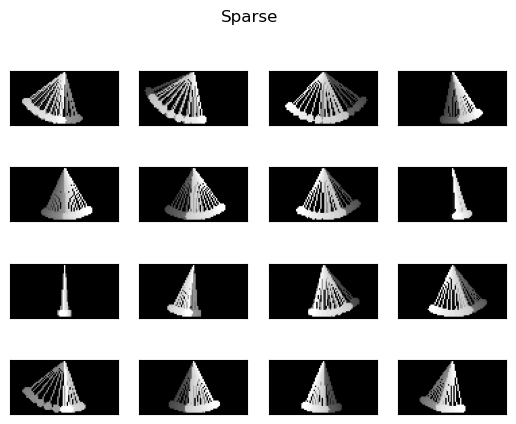

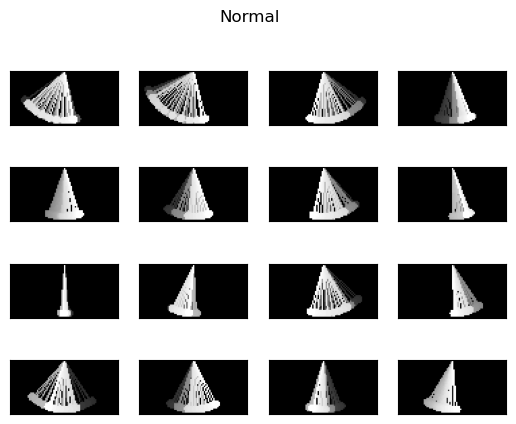

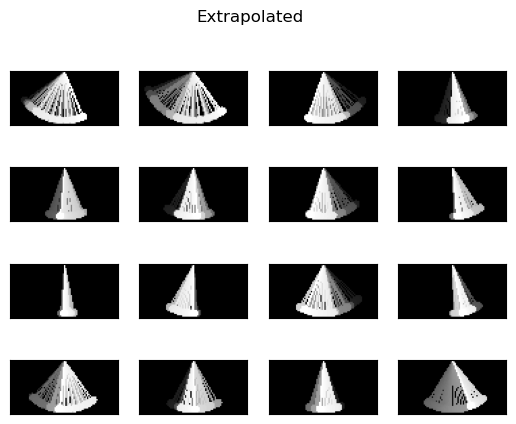

In [35]:
def make_heatmap(video, video_title):
    def heatmap(batch):
        video = np.array([t*v for t,v in enumerate(batch, start=1)])
        flat_video = np.max(video, 0)
        flat_video = 0.5 + flat_video / np.max(flat_video)
        return flat_video
        
    fig, axs = plt.subplots(4,4)  
    for i in range(4):
        for j in range(4):
            index = i*4+j 
            if index >= len(video):
                break
            heat_img = heatmap(video[index,:,:,:])
            axs[i,j].imshow(heat_img, cmap="gray")
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
        if index >= len(video):
            break
    fig.suptitle(video_title)
    fig.show()
    
video_titles = ["Sparse", "Normal", "Extrapolated"]
for i in range(len(videos)):
    make_heatmap(videos[i], video_titles[i])

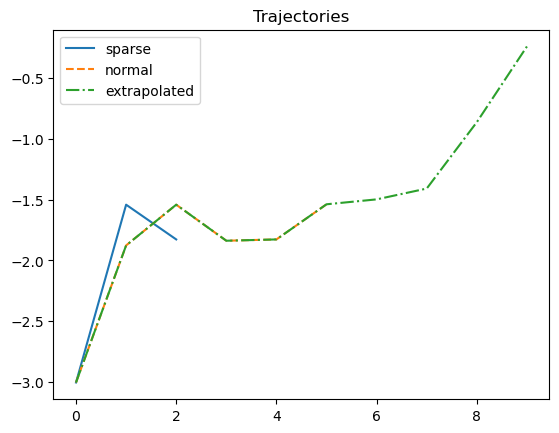

In [15]:
line_types = ['-', '--', '-.'] 
for i in range(3):  
    plt.plot(trajects[i][0,:,0], linestyle=line_types[i])
plt.legend(['sparse', 'normal', 'extrapolated'])
plt.title('Trajectories')
plt.show() 

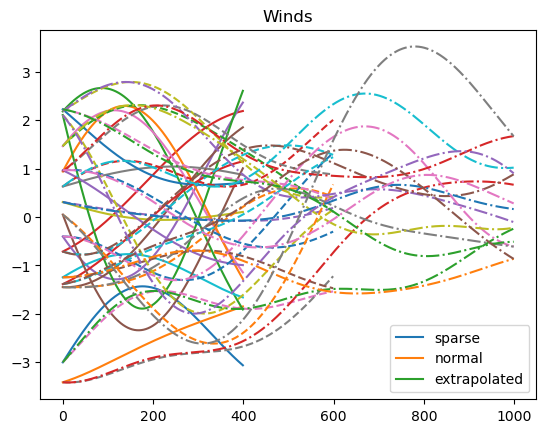

In [16]:
for i in range(3):  
    plt.plot(winds[i].T, linestyle=line_types[i])
plt.legend(['sparse', 'normal', 'extrapolated'])
plt.title('Winds')
plt.show() 

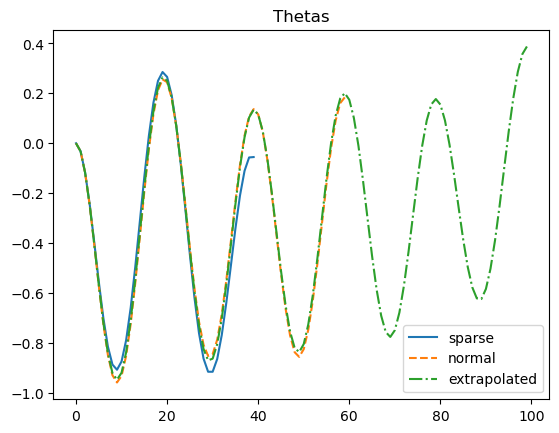

In [17]:
for i in range(3):  
    plt.plot(thetas[i][0], linestyle=line_types[i])
plt.legend(['sparse', 'normal', 'extrapolated'])
plt.title('Thetas')
plt.show() 

In [18]:
def get_coords(th):
    return l * np.sin(th), -l * np.cos(th)

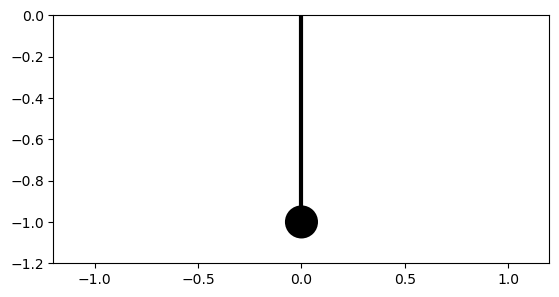

In [19]:
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
x0, y0 = get_coords(theta0)
bob_radius = 0.08
line, = ax.plot([0, x0], [0, y0], lw=3, c='k')
line.set_data([0, x0], [0, y0])
circle = ax.add_patch(plt.Circle(get_coords(theta0), bob_radius, fc='black', zorder=3))
ax.set_xlim(-l*1.2, l*1.2)
ax.set_ylim(-l*1.2, 0)
fig.show()

In [20]:
def make_animation(theta, video_title, time, subsample_step_size):
    new_dt = dt * subsample_step_size
    nframes = int(len(theta[0]))
    fps = nframes / time 
    def animate(i):
        x, y = get_coords(theta[0][i*int(1/fps/new_dt)])
        line.set_data([0, x], [0, y])
        circle.set_center((x, y))
     
    ani = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True, interval=1000/fps)
    plt.ion()
    plt.show()
    writervideo = animation.PillowWriter(fps=fps) 
    ani.save(f'../Gifs/{video_title}.gif', writer=writervideo) 

In [21]:
video_titles = [ "Sparse", "Normal", "Extrapolated"]
times = [gp_sparse_time, gp_trunc_time, gp_total_time]
for i in range(len(thetas)):
    make_animation(thetas[i][0].T, video_titles[i], times[i], subsample_step_size)